In [43]:
# 22010350
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [99]:
def get_common_stocks_by_sector(first_file_path, second_file_path, sector):
    # Load both datasets
    df1 = pd.read_csv(first_file_path)
    df2 = pd.read_csv(second_file_path)
    
    # Filter the first DataFrame for the specified sector
    sector_stocks = df1[df1['Sector'] == sector]['Symbol']
    
    # Get stocks present in the second DataFrame
    common_stocks = sector_stocks[sector_stocks.isin(df2['Symbol'])].tolist()
    
    return common_stocks

# Example usage
first_file_path = 'sp500_companies.csv'
second_file_path = 'sp500_stocks.csv'
sector = "Technology"
common_stocks_in_sector = get_common_stocks_by_sector(first_file_path, second_file_path, sector)
print(common_stocks_in_sector)

['MSFT', 'AAPL', 'NVDA', 'AVGO', 'ORCL', 'CRM', 'AMD', 'ADBE', 'QCOM', 'ACN', 'CSCO', 'INTU', 'AMAT', 'TXN', 'IBM', 'NOW', 'UBER', 'INTC', 'MU', 'LRCX', 'ADI', 'PANW', 'KLAC', 'FI', 'ANET', 'SNPS', 'CDNS', 'APH', 'NXPI', 'MSI', 'ROP', 'MCHP', 'ADSK', 'SMCI', 'FTNT', 'TEL', 'FIS', 'MPWR', 'IT', 'CTSH', 'GRMN', 'ON', 'CDW', 'FICO', 'GLW', 'ANSS', 'HPQ', 'FTV', 'KEYS', 'BR', 'WDC', 'HPE', 'NTAP', 'CPAY', 'PTC', 'FSLR', 'TYL', 'LDOS', 'TER', 'STX', 'TDY', 'VRSN', 'ZBRA', 'ENPH', 'AKAM', 'SWKS', 'JBL', 'EPAM', 'TRMB', 'GEN', 'JKHY', 'JNPR', 'PAYC', 'FFIV', 'QRVO', 'DAY']


In [106]:
# Define the list of technology sector stock symbols (replace with the variable if dynamic)
tech_stocks = ['NVDA', 'ORCL', 'IBM', 'PANW', 'MSI', 'ROP', 'SMCI', 'GRMN', 'FTV', 'BR', 'FSLR', 'TYL', 'LDOS', 'ENPH', 'AKAM', 'GEN', 'JKHY', 'JNPR', 'FFIV']

# Load your stock price data
stock_price_path = 'sp500_stocks.csv'
stock_data = pd.read_csv(stock_price_path)

# Get a list of unique stock symbols from the stock price data
available_stocks = stock_data['Symbol'].unique()

# Filter the tech_stocks list to include only those that are present in the available_stocks
filtered_tech_stocks = [stock for stock in tech_stocks if stock in available_stocks]

# Now filtered_tech_stocks contains only the stock symbols that are both in your tech_stocks list
# and present in your stock data. You can proceed with using this list for further analysis.
print("Filtered Technology Stocks:", filtered_tech_stocks)

Filtered Technology Stocks: ['NVDA', 'ORCL', 'IBM', 'PANW', 'MSI', 'ROP', 'SMCI', 'GRMN', 'FTV', 'BR', 'FSLR', 'TYL', 'LDOS', 'ENPH', 'AKAM', 'GEN', 'JKHY', 'JNPR', 'FFIV']


In [107]:
# Load and prepare data
filePath = 'sp500_stocks.csv'
stockData = pd.read_csv(filePath)
selectedStocks = filtered_tech_stocks
#selectedStocks = common_stocks_in_sector
filteredData = stockData[stockData['Symbol'].isin(selectedStocks)]
pivotData = filteredData.pivot(index='Date', columns='Symbol', values='Adj Close')
dailyReturns = pivotData.pct_change().dropna()

# Constants for the optimization
riskFreeRate = 0.01  # Assuming a risk-free rate of 1%

# Portfolio statistics functions
def portfolioAnnualisedPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return std, returns

def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    pVar, pRet = portfolioAnnualisedPerformance(weights, meanReturns, covMatrix)
    return -(pRet - riskFreeRate) / pVar

def maxSharpeRatio(meanReturns, covMatrix, riskFreeRate):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for asset in range(numAssets))
    result = minimize(negSharpeRatio, numAssets*[1./numAssets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolioVolatility(weights, meanReturns, covMatrix):
    return portfolioAnnualisedPerformance(weights, meanReturns, covMatrix)[0]

def minVariance(meanReturns, covMatrix):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.00, 1.0) for asset in range(numAssets))
    result = minimize(portfolioVolatility, numAssets*[1./numAssets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def randomPortfolios(numPortfolios, meanReturns, covMatrix, riskFreeRate):
    results = np.zeros((3, numPortfolios))
    weightsRecord = []
    for i in range(numPortfolios):
        weights = np.random.random(len(meanReturns))
        weights /= np.sum(weights)
        weightsRecord.append(weights)
        portfolioStdDev, portfolioReturn = portfolioAnnualisedPerformance(weights, meanReturns, covMatrix)
        results[0,i] = portfolioStdDev
        results[1,i] = portfolioReturn
        results[2,i] = (portfolioReturn - riskFreeRate) / portfolioStdDev
    return results, weightsRecord

# Calculate mean returns and covariance matrix
meanReturns = dailyReturns.mean()
covMatrix = dailyReturns.cov()

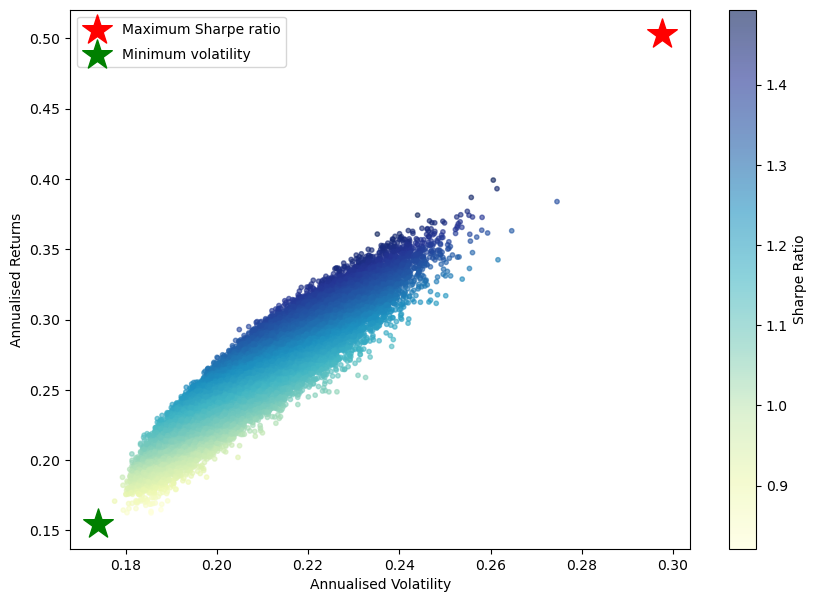

Maximum Sharpe Ratio Portfolio Weights:
NVDA: 0.000
ORCL: 0.000
IBM: 0.135
PANW: 0.000
MSI: 0.000
ROP: 0.000
SMCI: 0.000
GRMN: 0.031
FTV: 0.000
BR: 0.000
FSLR: 0.000
TYL: 0.163
LDOS: 0.219
ENPH: 0.263
AKAM: 0.000
GEN: 0.042
JKHY: 0.000
JNPR: 0.148
FFIV: 0.000
Annualized Return: 50.29%, Volatility: 29.76%


Minimum Volatility Portfolio Weights:
NVDA: 0.062
ORCL: 0.073
IBM: 0.000
PANW: 0.013
MSI: 0.010
ROP: 0.015
SMCI: 0.072
GRMN: 0.083
FTV: 0.157
BR: 0.163
FSLR: 0.065
TYL: 0.086
LDOS: 0.047
ENPH: 0.000
AKAM: 0.033
GEN: 0.009
JKHY: 0.065
JNPR: 0.000
FFIV: 0.046
Annualized Return: 15.44%, Volatility: 17.41%


In [108]:
results, weights = randomPortfolios(100000, meanReturns, covMatrix, riskFreeRate)

# Perform optimizations
maxSharpe = maxSharpeRatio(meanReturns, covMatrix, riskFreeRate)
minVol = minVariance(meanReturns, covMatrix)

# Extracting performance
maxSharpeStd, maxSharpeReturn = portfolioAnnualisedPerformance(maxSharpe.x, meanReturns, covMatrix)
minVolStd, minVolReturn = portfolioAnnualisedPerformance(minVol.x, meanReturns, covMatrix)

# Plotting the data
plt.figure(figsize=(10, 7))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolioAnnualisedPerformance(maxSharpe.x, meanReturns, covMatrix)[0], 
            portfolioAnnualisedPerformance(maxSharpe.x, meanReturns, covMatrix)[1], 
            marker='*', color='r', s=500, label='Maximum Sharpe ratio')
plt.scatter(portfolioAnnualisedPerformance(minVol.x, meanReturns, covMatrix)[0], 
            portfolioAnnualisedPerformance(minVol.x, meanReturns, covMatrix)[1], 
            marker='*', color='g', s=500, label='Minimum volatility')
plt.xlabel('Annualised Volatility')
plt.ylabel('Annualised Returns')
plt.legend(labelspacing=0.8)
plt.show()

# Print the weights
print("Maximum Sharpe Ratio Portfolio Weights:")
for i, stock in enumerate(selectedStocks):
    print(f"{stock}: {maxSharpe.x[i]:.3f}")
print(f"Annualized Return: {maxSharpeReturn:.2%}, Volatility: {maxSharpeStd:.2%}\n")

print("\nMinimum Volatility Portfolio Weights:")
for i, stock in enumerate(selectedStocks):
    print(f"{stock}: {minVol.x[i]:.3f}")
print(f"Annualized Return: {minVolReturn:.2%}, Volatility: {minVolStd:.2%}")

In [109]:
# Cluster 1 profits before covid, stagnation since
# Cluster 2 high recent boom, NVDA and microchip
# Cluster 3 affected aversely by covid, made a recovery midway
# Cluster 4 like cluster 3 but includes cybersecurity

# Cluster 1:
# Max Sharpe performance Annualized Return: 29.97%, Volatility: 22.43%
# Min Volati performance Annualized Return: 17.85%, Volatility: 17.43%

# Cluster 2:
# Max Sharpe performance Annualized Return: 46.93%, Volatility: 40.79%
# Min Volati performance Annualized Return: 46.89%, Volatility: 40.78%

# Cluster 3:
# Max Sharpe performance Annualized Return: 23.43%, Volatility: 33.63%
# Min Volati performance Annualized Return: 8.98%, Volatility: 20.76%

# Cluster 4:
# Max Sharpe performance Annualized Return: 16.82%, Volatility: 25.18%
# Min Volati performance Annualized Return: 13.11%, Volatility: 21.90%

# Experiment 1:
# Max Sharpe performance Annualized Return: 47.21%, Volatility: 44.76%
# Min Volati performance Annualized Return: 16.37%, Volatility: 29.90%


# Experiment 2:
# Max Sharpe performance Annualized Return: 50.29%, Volatility: 29.76%
# Min Volati performance Annualized Return: 15.44%, Volatility: 17.41%


In [111]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def iterative_optimization(min_weight_threshold, riskFreeRate):
    selected_stocks = filtered_tech_stocks
    while True:
        if len(selected_stocks) < 2:
            print("Not enough stocks left to form a diversified portfolio.")
            break

        filtered_data = pivotData[selected_stocks]
        mean_returns = filtered_data.pct_change().dropna().mean()
        cov_matrix = filtered_data.pct_change().dropna().cov()

        # Optimize for maximum Sharpe ratio
        max_sharpe = maxSharpeRatio(mean_returns, cov_matrix, riskFreeRate)
        max_sharpe_weights = max_sharpe.x
        max_sharpe_std, max_sharpe_return = portfolioAnnualisedPerformance(max_sharpe_weights, mean_returns, cov_matrix)
        
        # Optimize for minimum volatility
        min_vol = minVariance(mean_returns, cov_matrix)
        min_vol_weights = min_vol.x
        min_vol_std, min_vol_return = portfolioAnnualisedPerformance(min_vol_weights, mean_returns, cov_matrix)

        # Determine stocks to keep based on the threshold
        stocks_to_keep = [stock for i, stock in enumerate(selected_stocks)
                          if max_sharpe_weights[i] > min_weight_threshold or min_vol_weights[i] > min_weight_threshold]

        print(f"Remaining stocks: {stocks_to_keep}")

        if len(stocks_to_keep) == len(selected_stocks):
            print("Optimization converged. Final set of stocks selected.")
            break

        selected_stocks = stocks_to_keep

        # Plot current iteration
        plot_portfolios(mean_returns, cov_matrix, selected_stocks, max_sharpe_weights, min_vol_weights)

def plot_portfolios(mean_returns, cov_matrix, selected_stocks, max_sharpe_weights, min_vol_weights):
    max_sharpe_std, max_sharpe_return = portfolioAnnualisedPerformance(max_sharpe_weights, mean_returns, cov_matrix)
    min_vol_std, min_vol_return = portfolioAnnualisedPerformance(min_vol_weights, mean_returns, cov_matrix)

    plt.figure(figsize=(10, 7))
    plt.scatter(max_sharpe_std, max_sharpe_return, color='red', marker='*', s=200, label='Maximum Sharpe Ratio')
    plt.scatter(min_vol_std, min_vol_return, color='green', marker='*', s=200, label='Minimum Volatility')
    plt.title('Efficient Frontier with Iterative Optimization')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.show()

# Constants and initial configuration
riskFreeRate = 0.01
min_weight_threshold = 0.001  # Threshold for stock weights

# Start the iterative optimization process
iterative_optimization(min_weight_threshold, riskFreeRate)

Remaining stocks: ['NVDA', 'ORCL', 'IBM', 'PANW', 'MSI', 'ROP', 'SMCI', 'GRMN', 'FTV', 'BR', 'FSLR', 'TYL', 'LDOS', 'ENPH', 'AKAM', 'GEN', 'JKHY', 'JNPR', 'FFIV']
Optimization converged. Final set of stocks selected.
